In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

from ipynb.fs.full.common import *


In [2]:
# load gameplays
gameplays = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\gameplays.json").readlines()).apply(json.loads))
gameplays = preprocess_gameplays(gameplays)
gameplays = add_distance_per_jump(gameplays)

In [3]:
# load questionresponses and expand the response columns to contain "lastentry" and "secondlastentry" instead of 'A', 'B' or 'BOTH'
questionresponses = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\questionresponses.json").readlines()).apply(json.loads))
questionresponses = expand_questionresponses(questionresponses)

In [4]:
gameplays.shape

(1042, 88)

In [5]:
gameplays['invertedGameOver'].groupby(gameplays['invertedGameOver']).count()

invertedGameOver
False    989
True      53
Name: invertedGameOver, dtype: int64

In [6]:
53/1042

0.0508637236084453

<ipython-input-14-e4dcab4c3ec7>:99: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rotation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_name + 'night_mode_distance.png', rotation=False)


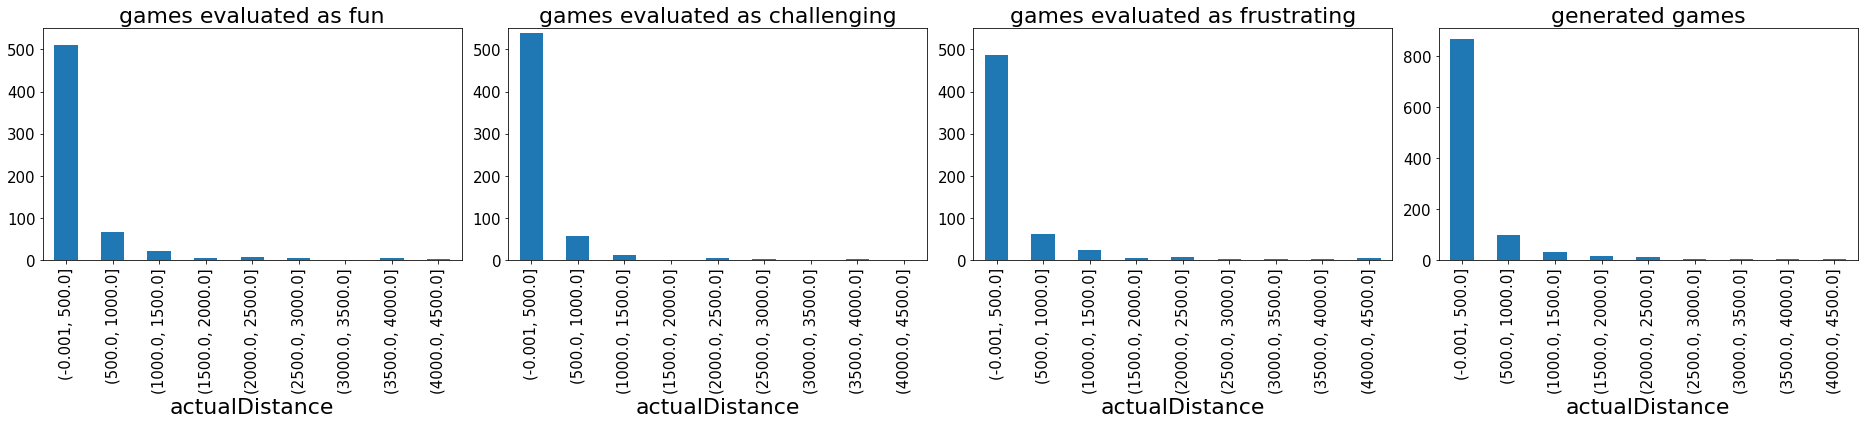

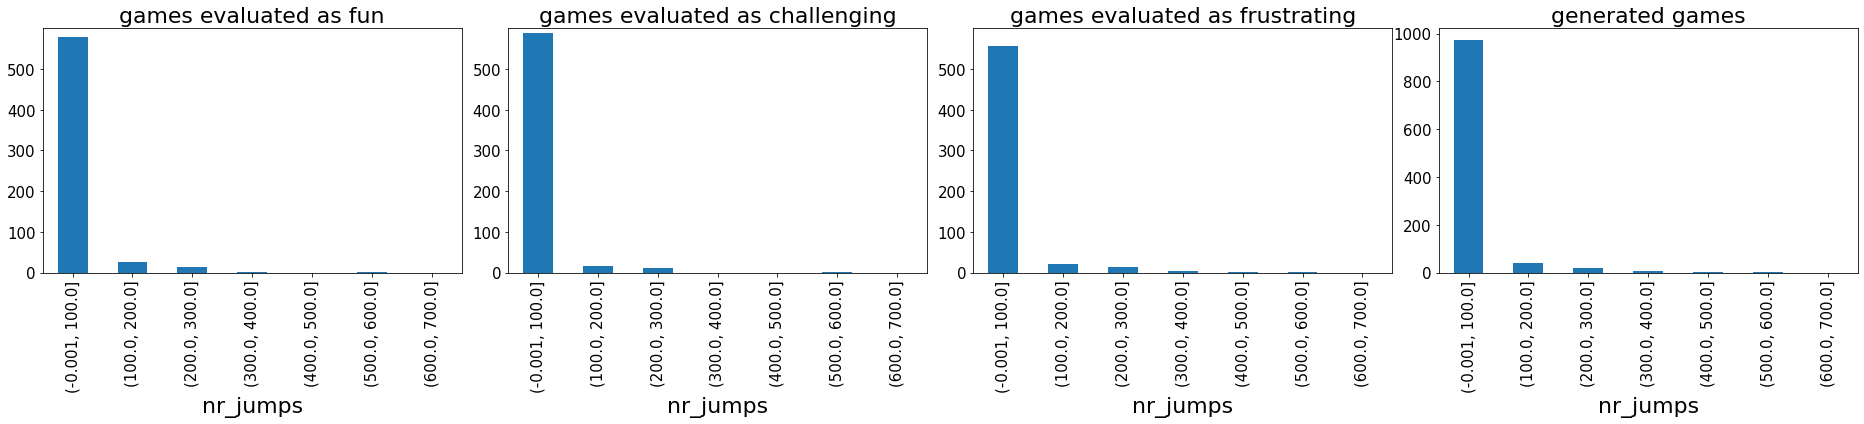

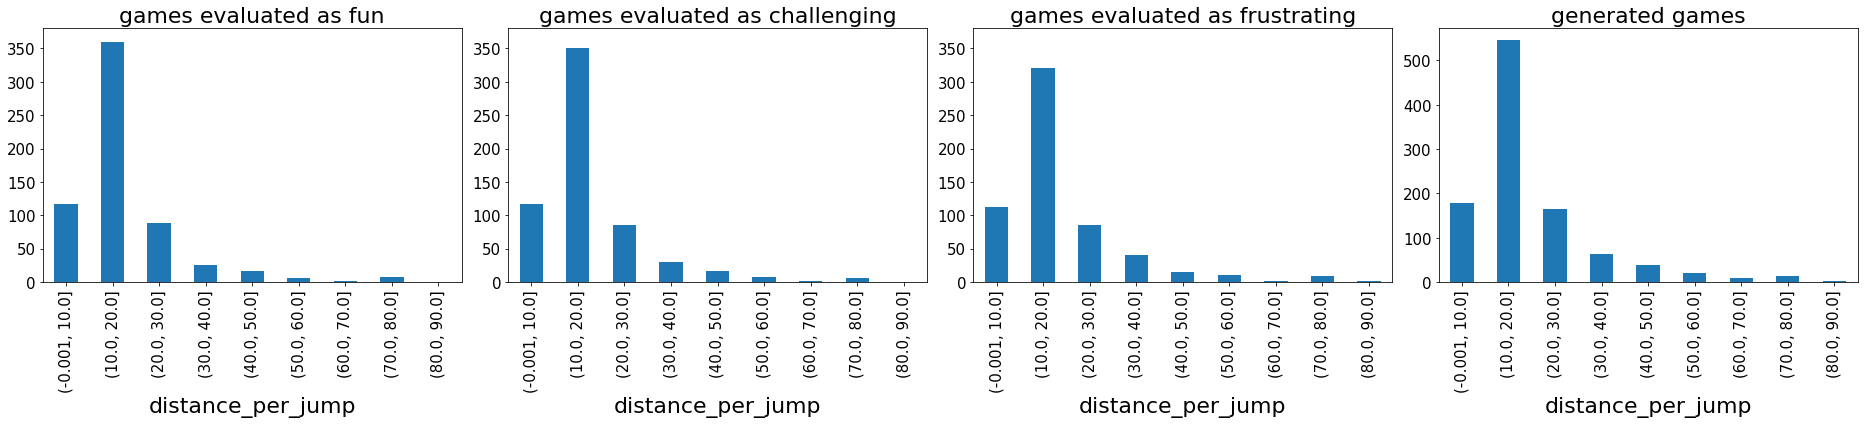

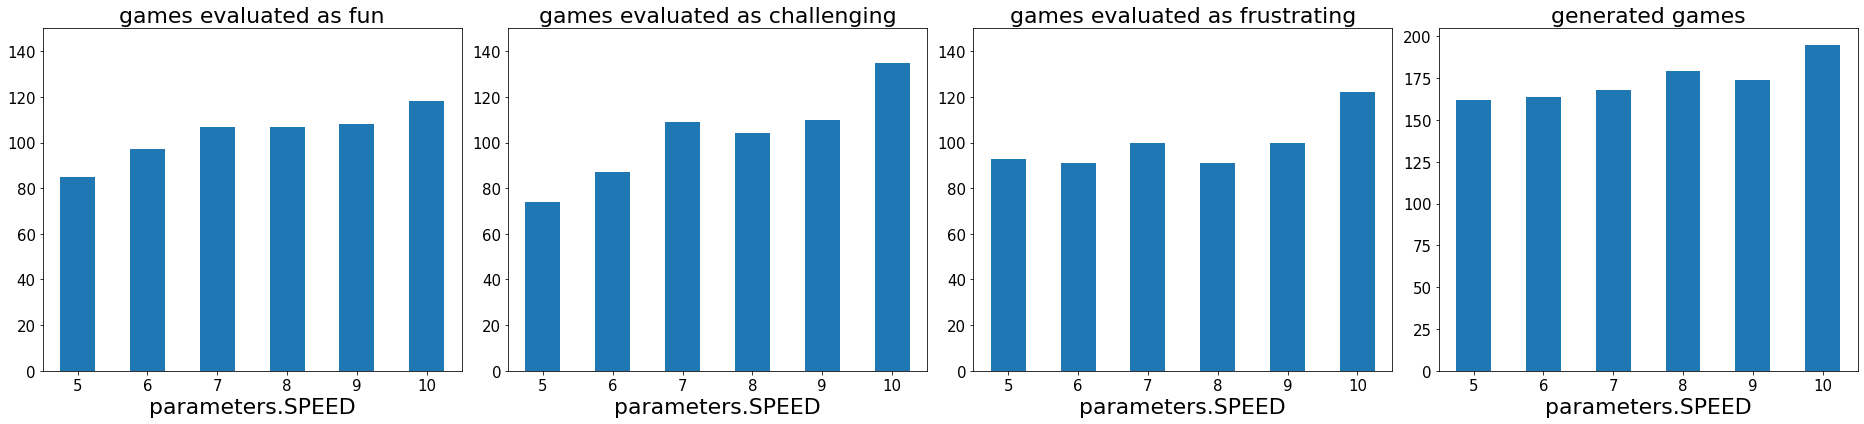

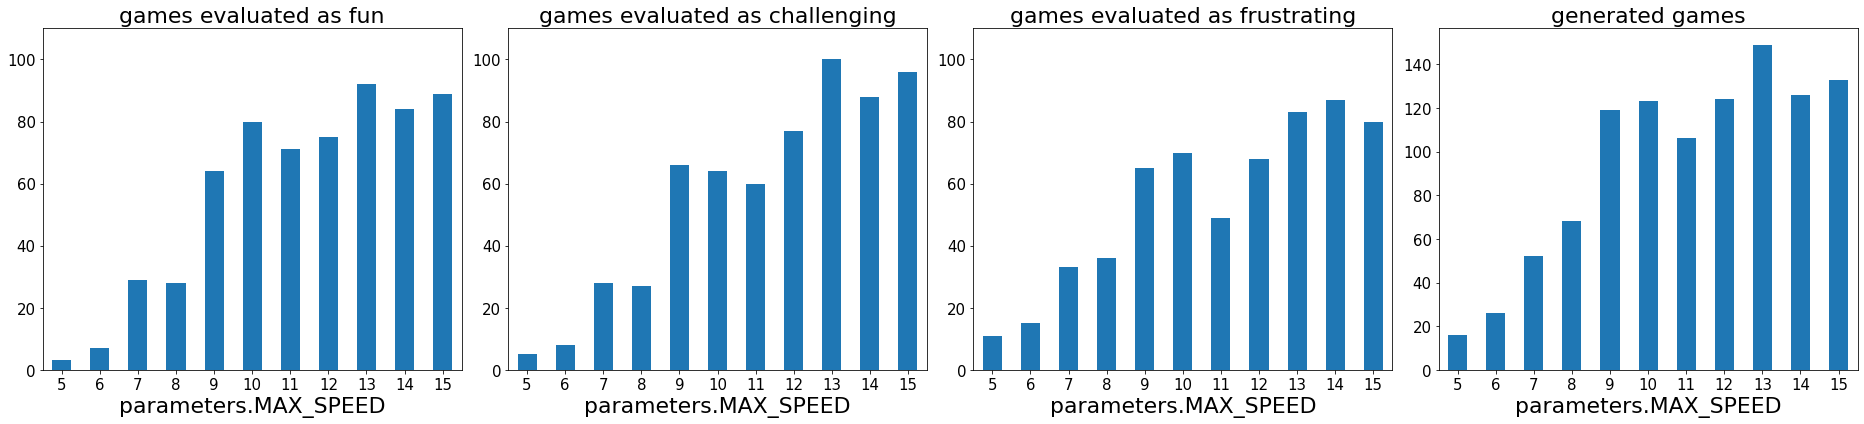

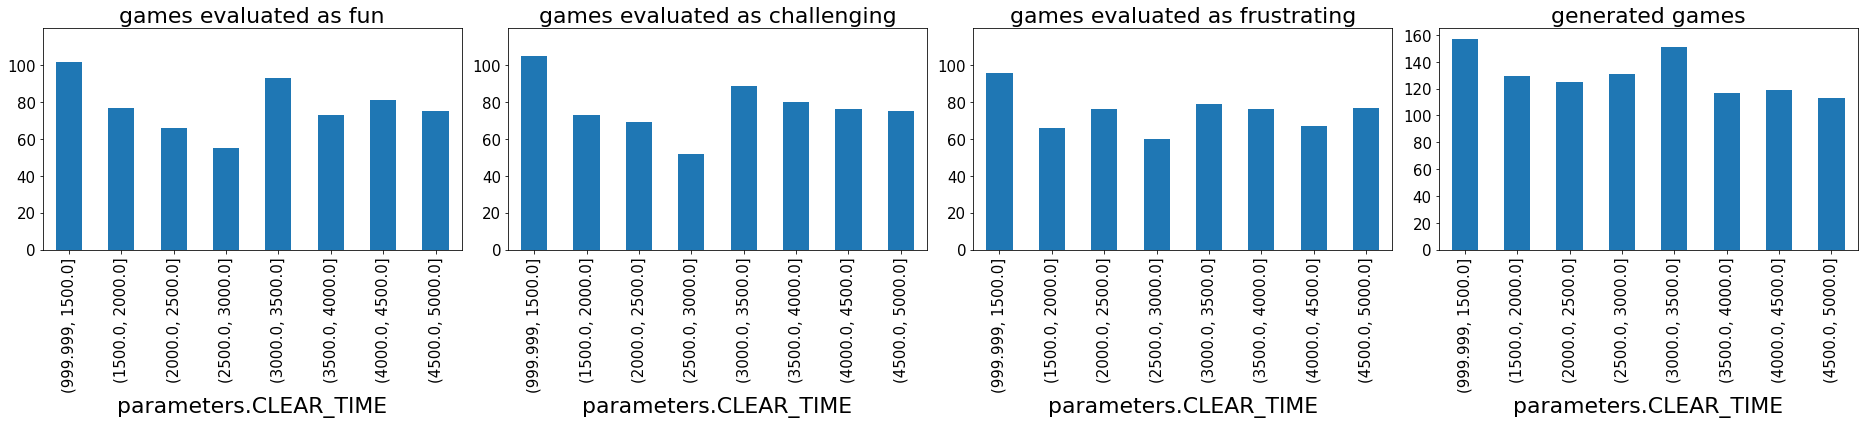

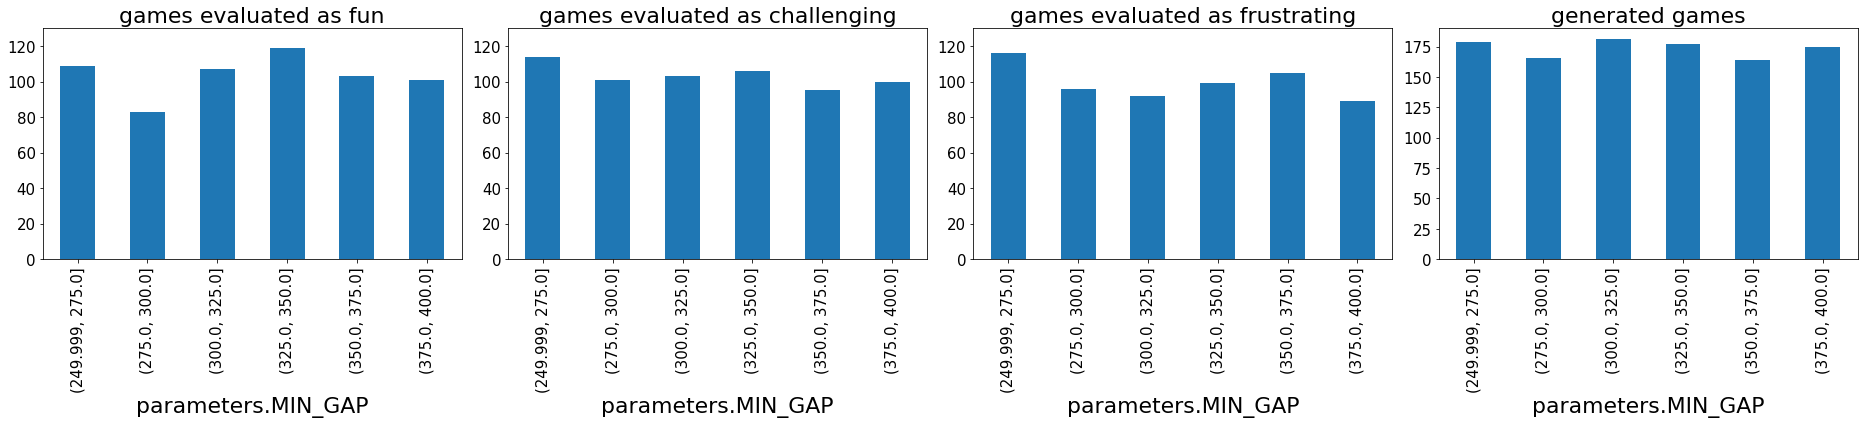

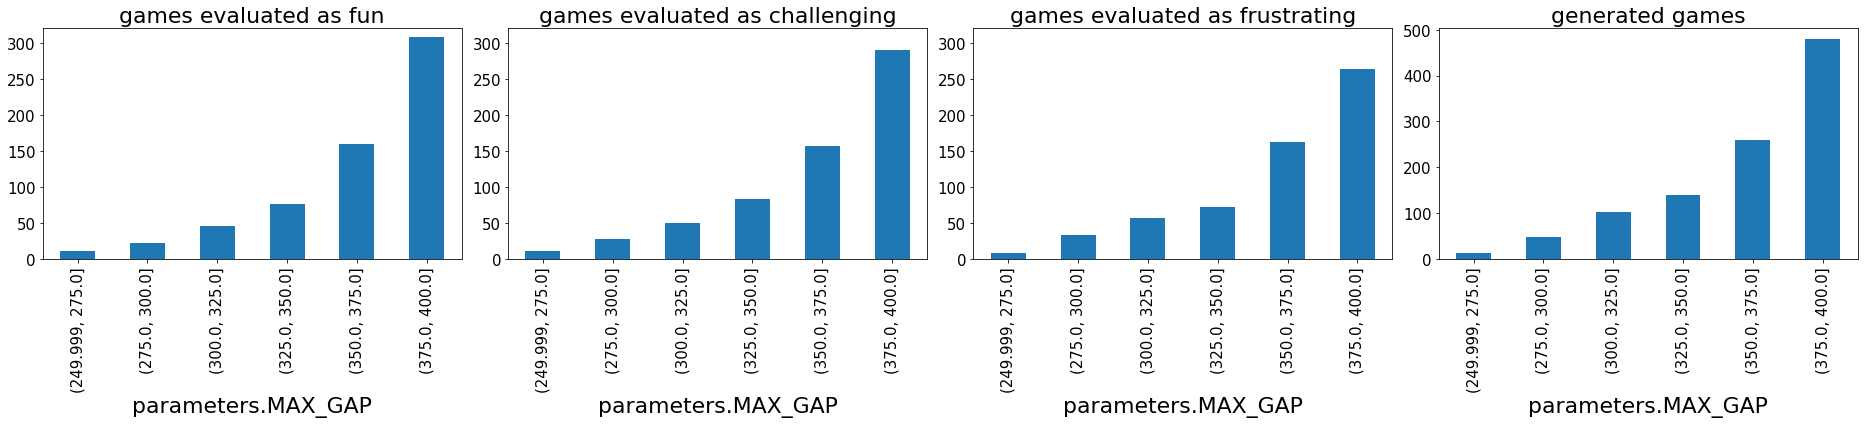

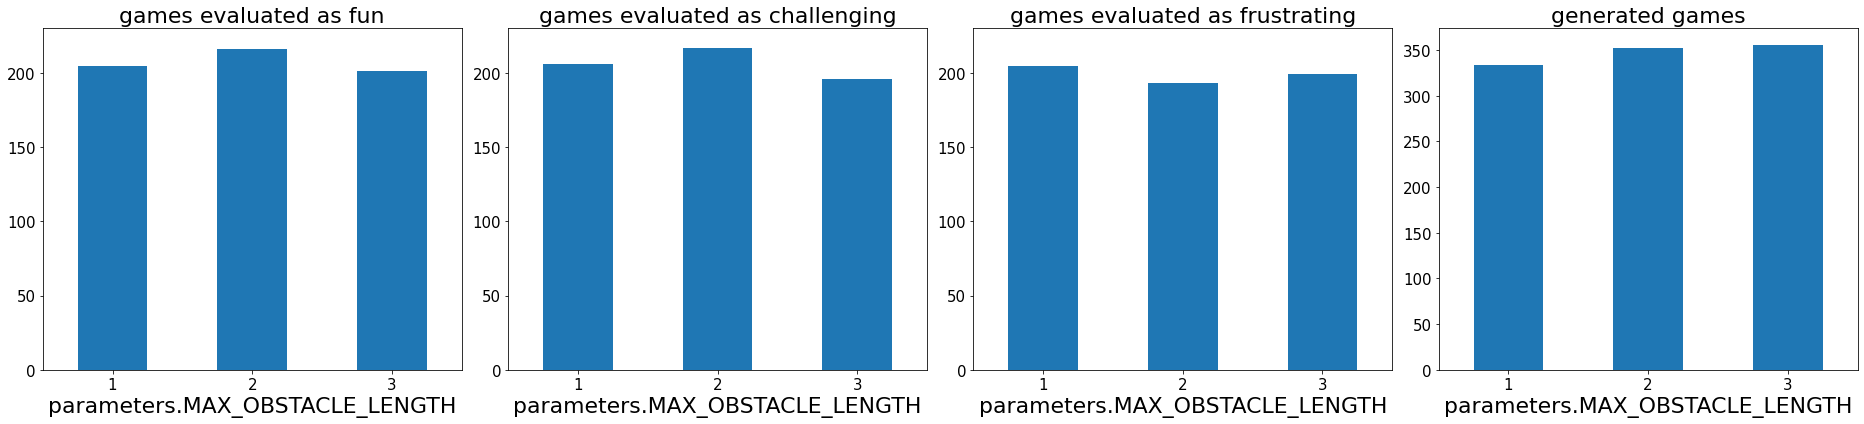

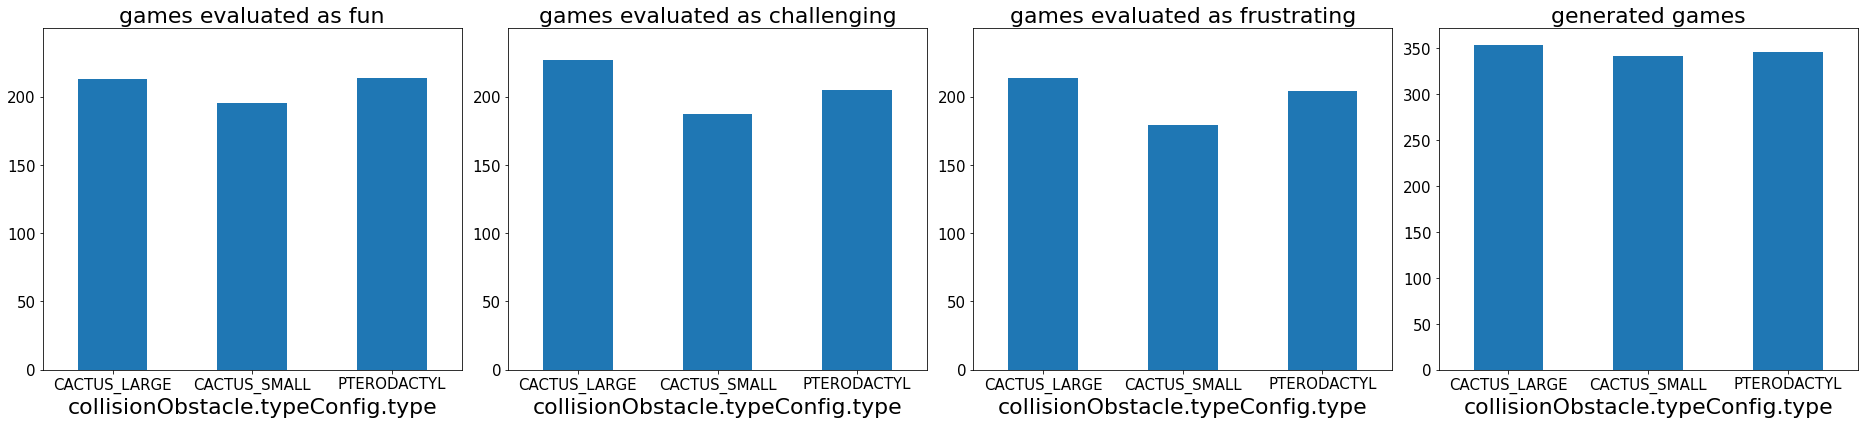

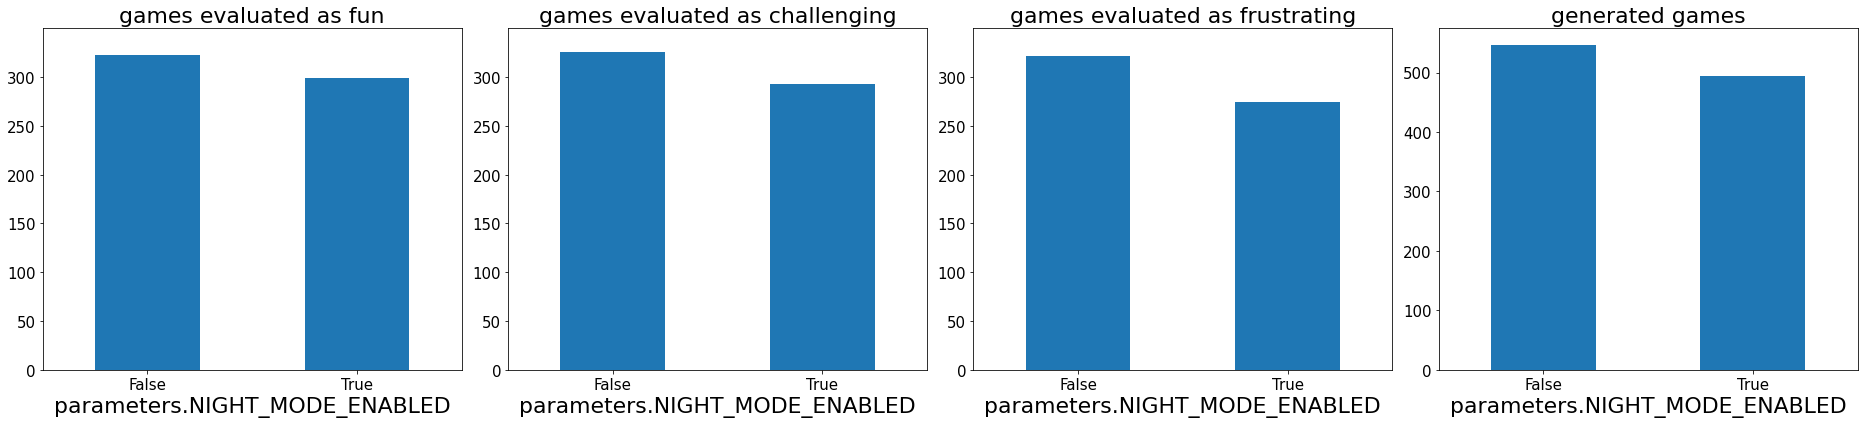

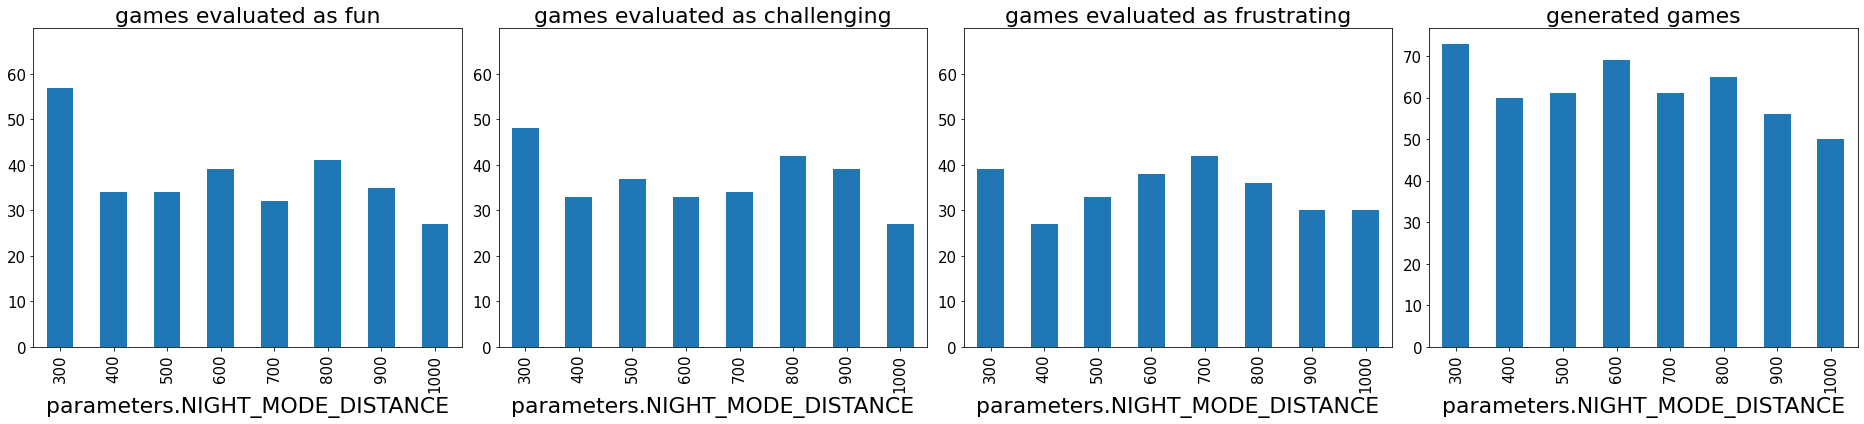

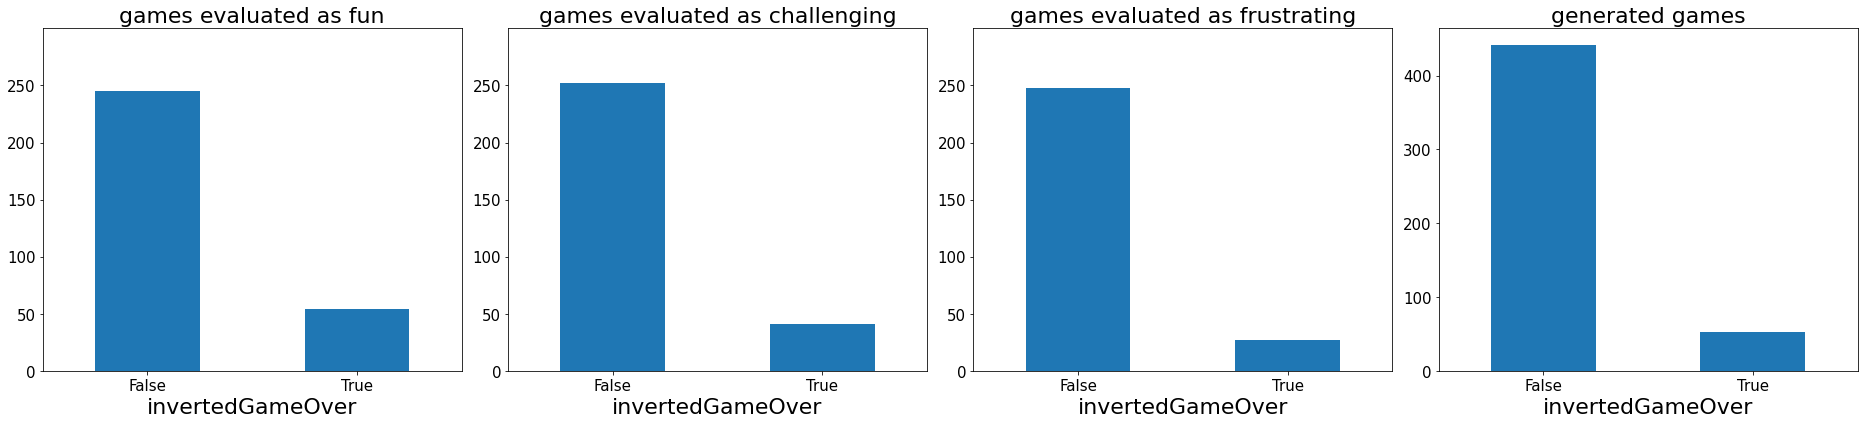

In [14]:
def explode_positive_counts_of(x): # questionresonses
    a = questionresponses
    a = a.explode(x)
    a['selected'] = np.where(a[x]=='secondlastentry', a['secondlastentry'], a['lastentry'])
    return a[[x, 'selected']]


def append_column_on_selected_id(db, parameter):
    a = db.merge(gameplays, left_on='selected', right_on='_id.$oid')
    return a[[parameter, "selected"]]

# ---
    
def group_positive_counts(column, group, bins = None):
    exploded = explode_positive_counts_of(column)
    s = append_column_on_selected_id(exploded, group)
    if(bins):
        c = pd.cut(s[group], bins = bins, include_lowest=True)
        counts = c.value_counts().reindex(c.cat.categories)
    else:
        counts = s[group].groupby(s[group]).count()
    return counts

def generated_group_counts(group, bins = None):
    if(bins):
        c = pd.cut(gameplays[group], bins, include_lowest=True)
        generated_counts = c.value_counts().reindex(c.cat.categories)
    else:
        generated_counts = gameplays[group].groupby(gameplays[group]).count()
    return generated_counts
        
columns = ["fun", "challenging", "frustrating"]
def draw_positive_counts(group, y_max_range, bins = None, rotation=True):
    plt.figure(figsize=(26, 6))
    for i, column in enumerate(columns):
        plt.subplot(1, 4, i+1)
        counts = group_positive_counts(column, group, bins)
        ax = counts.plot(kind="bar", fontsize=15)
        ax.set_title("games evaluated as " + column, fontsize=22)
        ax.set_xlabel(group, fontsize=22)
        ticks = nice_ticks(0, y_max_range, 10)
        ax.yaxis.set_ticks(ticks)
        ax.set_ylim([0,y_max_range])
        if not rotation:
            plt.xticks(rotation=0)
        plt.tight_layout()
    plt.subplot(1, 4, 4)
    generated_counts = generated_group_counts(group, bins)
    ax = generated_counts.plot(kind="bar", fontsize=15)
    ax.set_title("generated games", fontsize=22)
    ax.set_xlabel(group, fontsize=22)
    if not rotation:
        plt.xticks(rotation=0)

# ! only use this for discrete values !
if(True):
    fig_name = "graphs/notebook/histograms/not_normalized/evaluations_not_normalized_"
    
    draw_positive_counts("actualDistance", 550, bins = list(range(0,5000,500)))
    plt.savefig(fig_name + 'actualDistance.png')
    
    draw_positive_counts("nr_jumps", 600, bins = list(range(0,800,100)))
    plt.savefig(fig_name + 'nr_jumps.png')
    
    draw_positive_counts("distance_per_jump", 380, bins = list(range(0,100,10)))
    plt.savefig(fig_name + 'distance_per_jump.png')
    
    draw_positive_counts("parameters.SPEED", 150, rotation=False)
    plt.savefig(fig_name + 'speed.png')
    
    draw_positive_counts("parameters.MAX_SPEED", 110, rotation=False)
    plt.savefig(fig_name + 'max_speed.png')
    
    draw_positive_counts("parameters.CLEAR_TIME", 120, bins = list(range(1000, 5001, 500)))
    plt.savefig(fig_name + 'clear_time.png')
    
    draw_positive_counts("parameters.MIN_GAP", 130, bins = list(range(250,401,25)))
    plt.savefig(fig_name + 'min_gap.png')
    
    draw_positive_counts("parameters.MAX_GAP", 320, bins = list(range(250,401,25)))
    plt.savefig(fig_name + 'max_gap.png')
    
    draw_positive_counts("parameters.MAX_OBSTACLE_LENGTH", 230, rotation=False)
    plt.savefig(fig_name + 'obstacle_length.png')
    
    draw_positive_counts("collisionObstacle.typeConfig.type", 250, rotation=False)
    plt.savefig(fig_name + 'collisionObstacle.png')
    
    draw_positive_counts("parameters.NIGHT_MODE_ENABLED", 350, rotation=False)
    plt.savefig(fig_name + 'night_mode_enabled.png')
    
    # conditional: night_mode_distance and invertedGameOver only for games where night_mode_enabled
    # ---------------------------------------------------------------------------------------------
    old_gameplays = gameplays
    sub = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
    gameplays = sub

    draw_positive_counts("parameters.NIGHT_MODE_DISTANCE", 70)
    plt.savefig(fig_name + 'night_mode_distance.png', rotation=False)  
    
    draw_positive_counts("invertedGameOver", 300, rotation=False)
    plt.savefig(fig_name + 'invertedGameOver.png')
    
    gameplays = old_gameplays
    # ---------------------------------------------------------------------------------------------

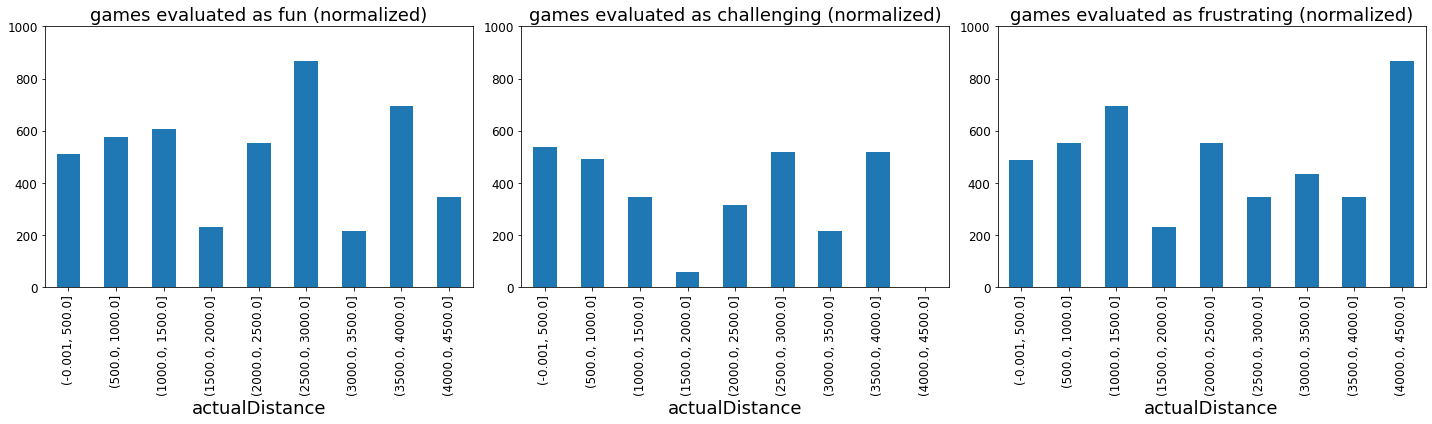

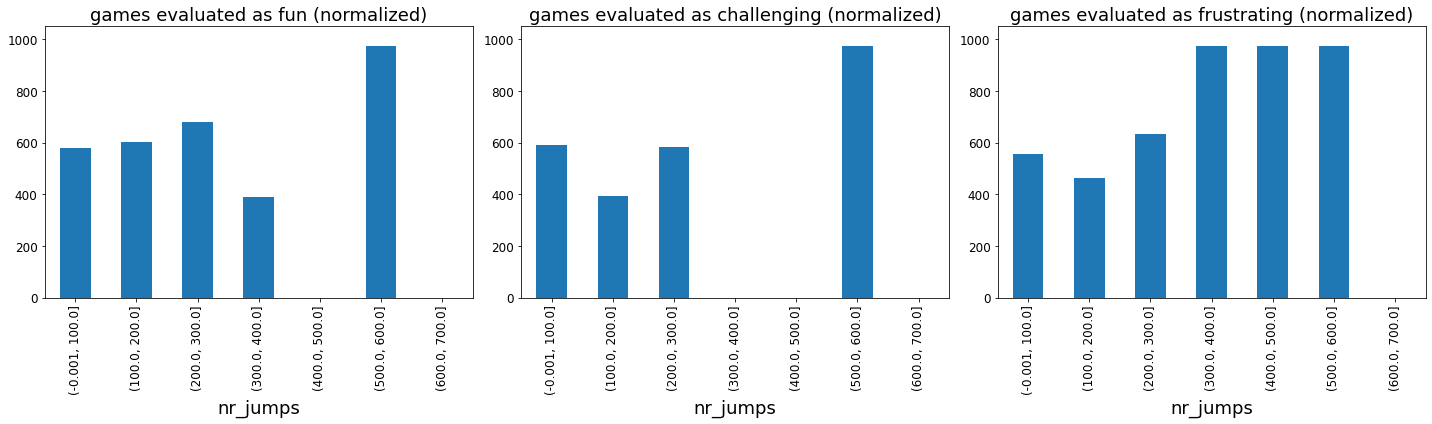

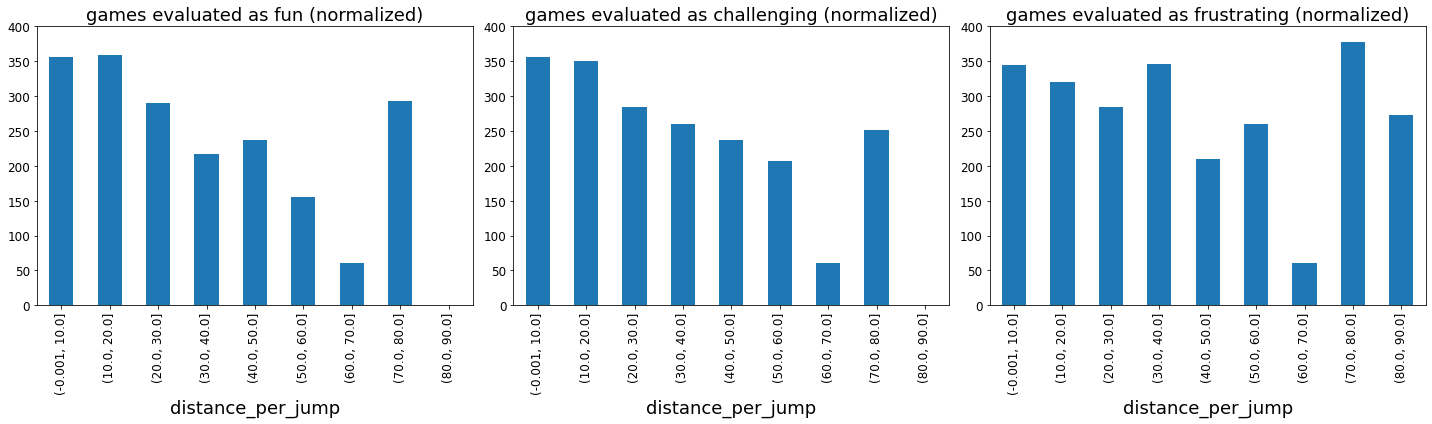

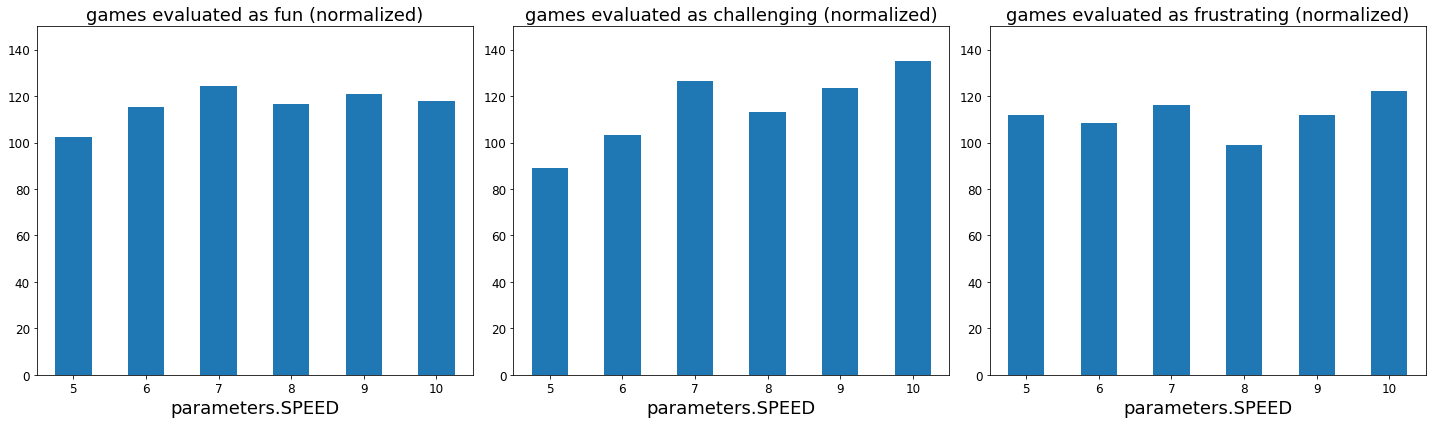

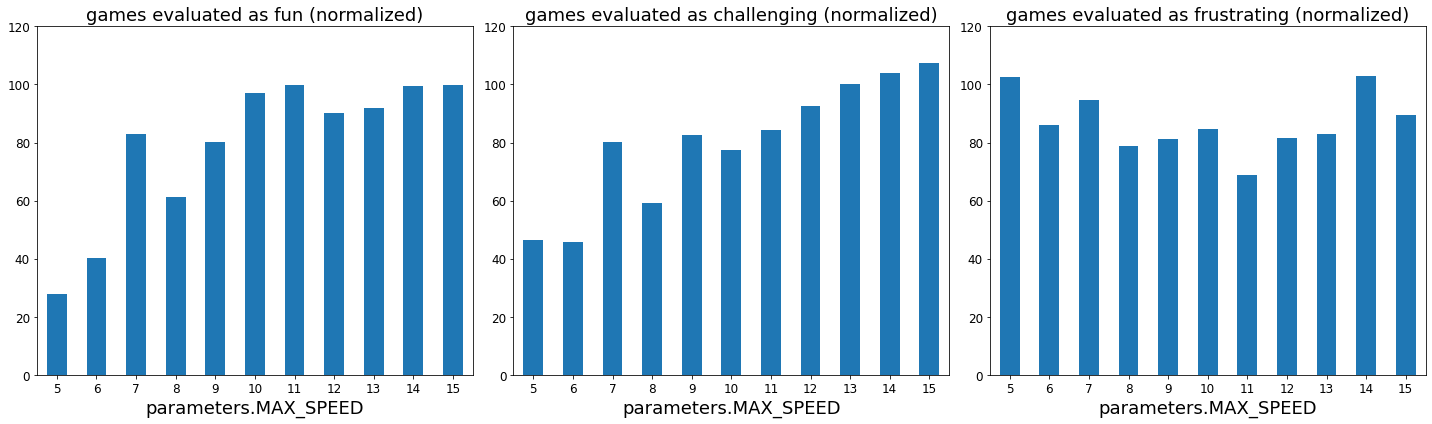

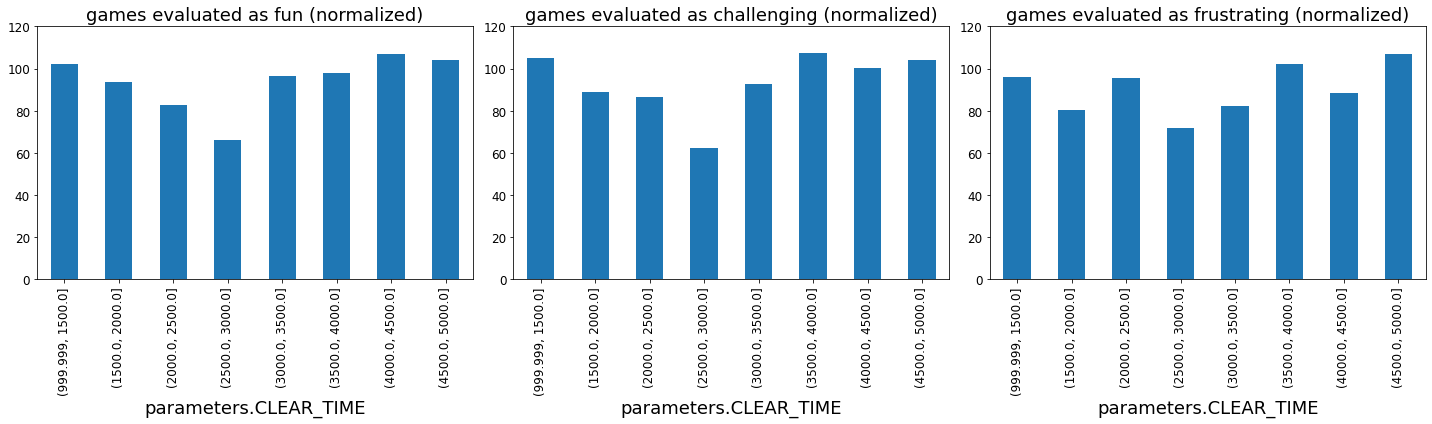

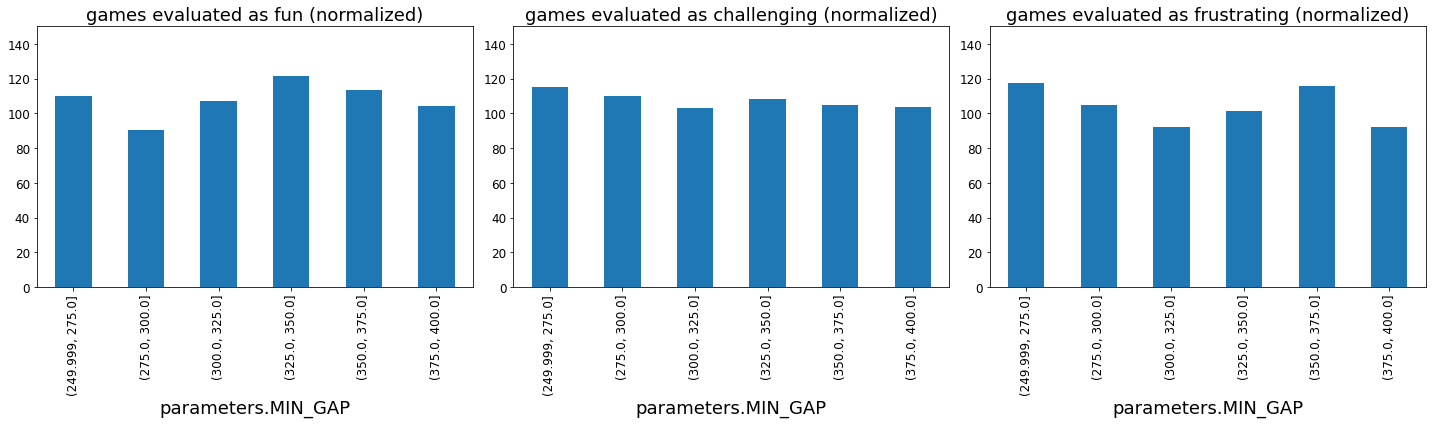

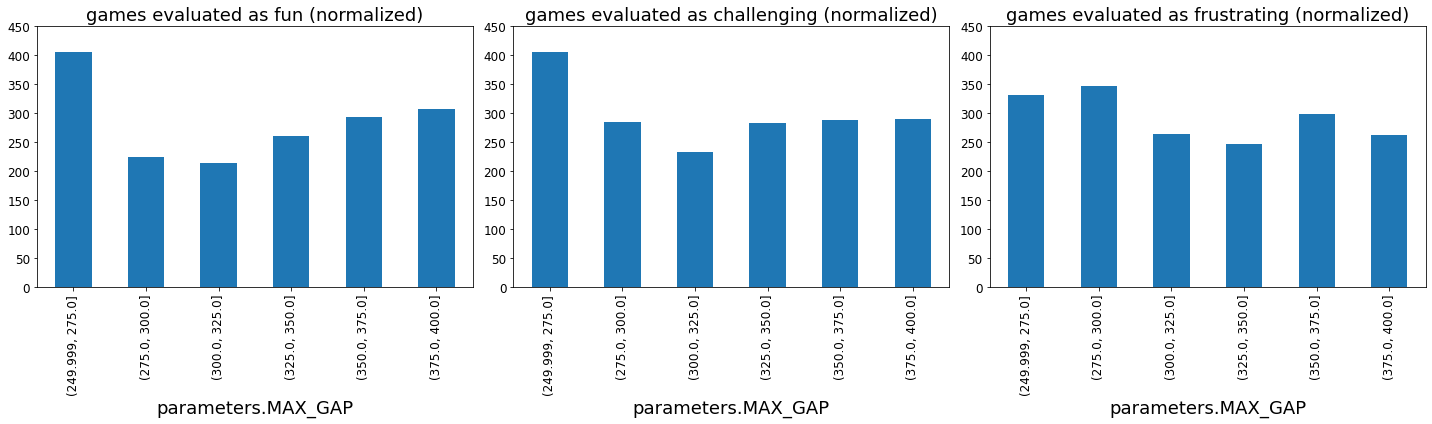

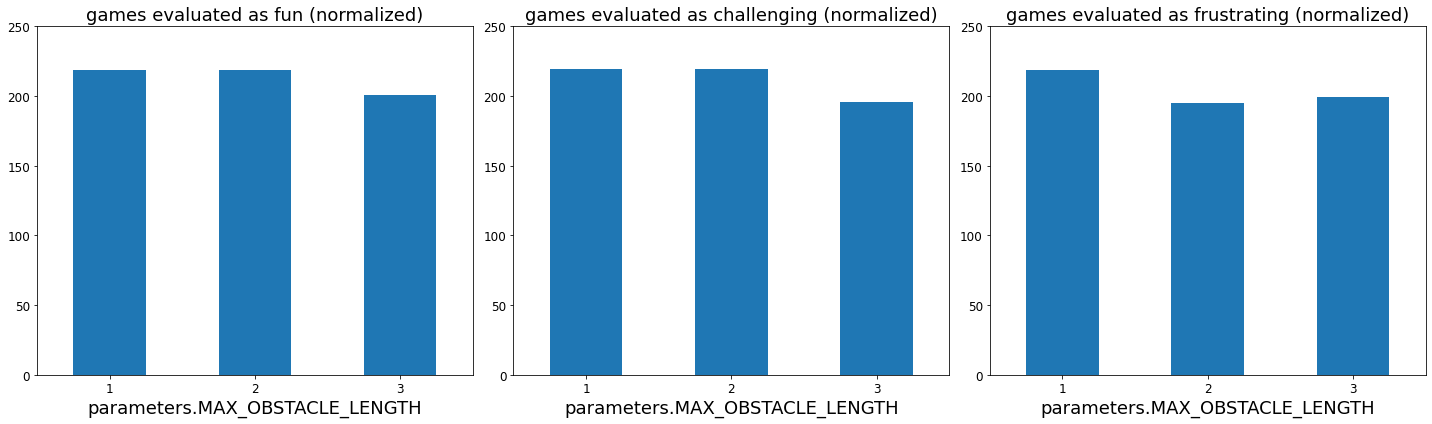

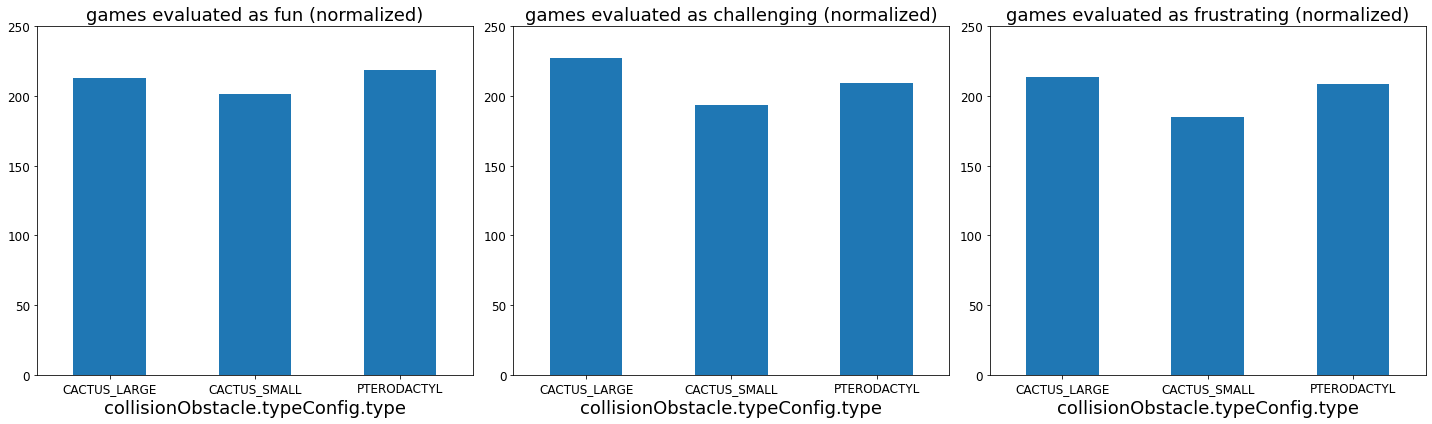

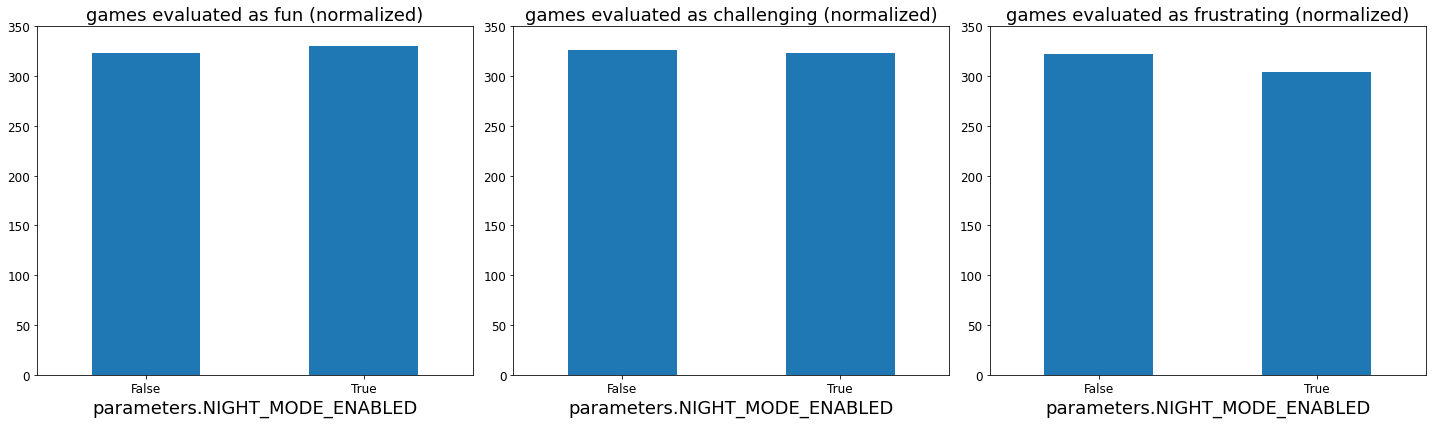

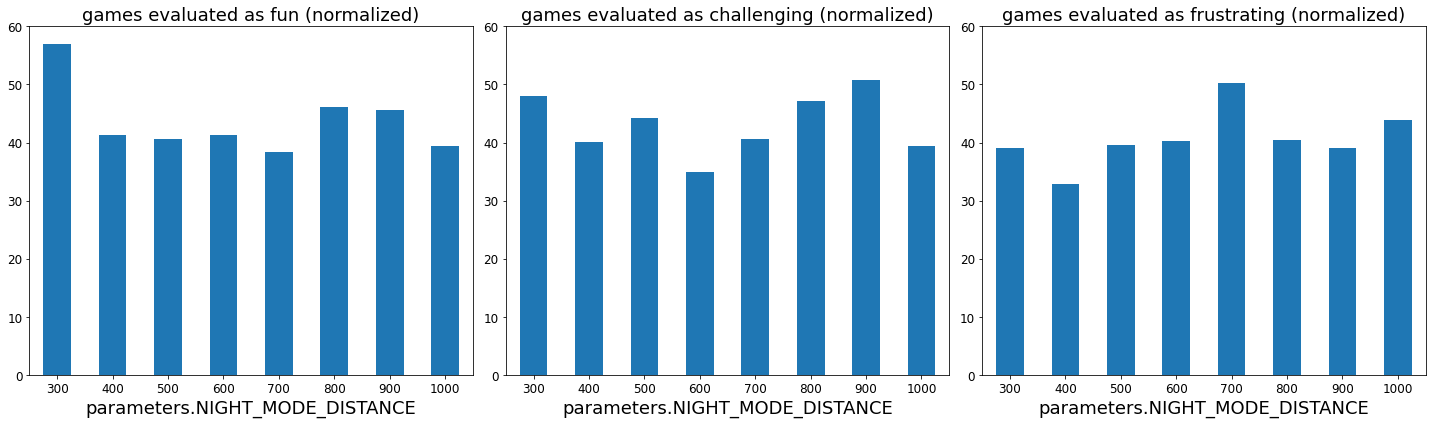

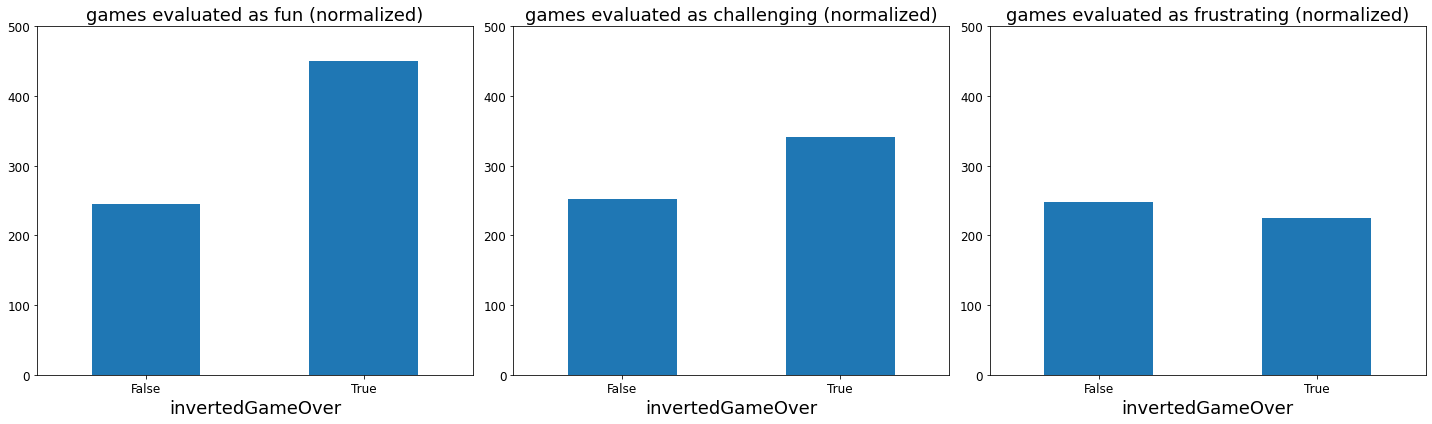

In [15]:
columns = ["fun", "challenging", "frustrating"]
def draw_positive_counts_normalized(group, y_max_range, bins = None, rotation=True):
    plt.figure(figsize=(20, 6))
    for i, column in enumerate(columns):
        plt.subplot(1, 3, i+1)
        counts = group_positive_counts(column, group, bins)
        generated = generated_group_counts(group, bins)
        generated_max = generated.max()
        factors = generated_max / generated
        counts_normalized = counts * factors
        ax = counts_normalized.plot(kind="bar", xlabel=group, fontsize=12)
        ax.set_title("games evaluated as " + column + " (normalized)", fontsize=18)
        ax.set_xlabel(group, fontsize=18)
        ax.set_ylim([0,y_max_range])
        if not rotation:
            plt.xticks(rotation=0)
        plt.tight_layout()

# ! only use this for discrete values !
if(True):
    fig_name = "graphs/notebook/histograms/normalized/evaluations_normalized_"
    
    draw_positive_counts_normalized("actualDistance", 1000, list(range(0,5000,500)))
    plt.savefig(fig_name + 'actualDistance.png')
    
    draw_positive_counts_normalized("nr_jumps", 1050,  list(range(0,800,100)))
    plt.savefig(fig_name + 'nr_jumps.png')
    
    draw_positive_counts_normalized("distance_per_jump", 400,  list(range(0,100,10)))
    plt.savefig(fig_name + 'distance_per_jump.png')
    
    draw_positive_counts_normalized("parameters.SPEED", 150, rotation=False)
    plt.savefig(fig_name + 'speed.png')
    
    draw_positive_counts_normalized("parameters.MAX_SPEED", 120, rotation=False)
    plt.savefig(fig_name + 'max_speed.png')
    
    draw_positive_counts_normalized("parameters.CLEAR_TIME", 120, list(range(1000, 5001, 500)))
    plt.savefig(fig_name + 'clear_time.png')
    
    draw_positive_counts_normalized("parameters.MIN_GAP", 150, list(range(250,401,25)))
    plt.savefig(fig_name + 'min_gap.png')
    
    draw_positive_counts_normalized("parameters.MAX_GAP", 450, list(range(250,401,25)))
    plt.savefig(fig_name + 'max_gap.png')
    
    draw_positive_counts_normalized("parameters.MAX_OBSTACLE_LENGTH", 250, rotation=False)
    plt.savefig(fig_name + 'obstacle_length.png')
    
    draw_positive_counts_normalized("collisionObstacle.typeConfig.type", 250, rotation=False)
    plt.savefig(fig_name + 'collisionObstacle.png')
    
    draw_positive_counts_normalized("parameters.NIGHT_MODE_ENABLED", 350, rotation=False)
    plt.savefig(fig_name + 'night_mode_enabled.png')
    
    # conditional: night_mode_distance and invertedGameOver only for games where night_mode_enabled
    # ---------------------------------------------------------------------------------------------
    old_gameplays = gameplays
    sub = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
    gameplays = sub

    draw_positive_counts_normalized("parameters.NIGHT_MODE_DISTANCE", 60, rotation=False)
    plt.savefig(fig_name + 'night_mode_distance.png')    
    
    draw_positive_counts_normalized("invertedGameOver", 500, rotation=False)
    plt.savefig(fig_name + 'invertedGameOver.png')
    
    gameplays = old_gameplays
    # ---------------------------------------------------------------------------------------------

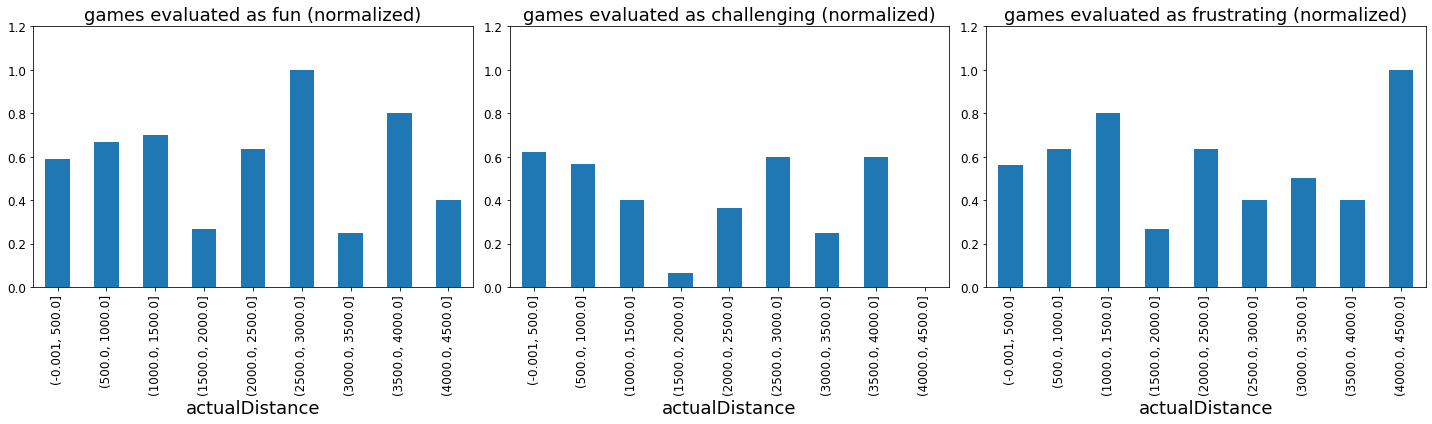

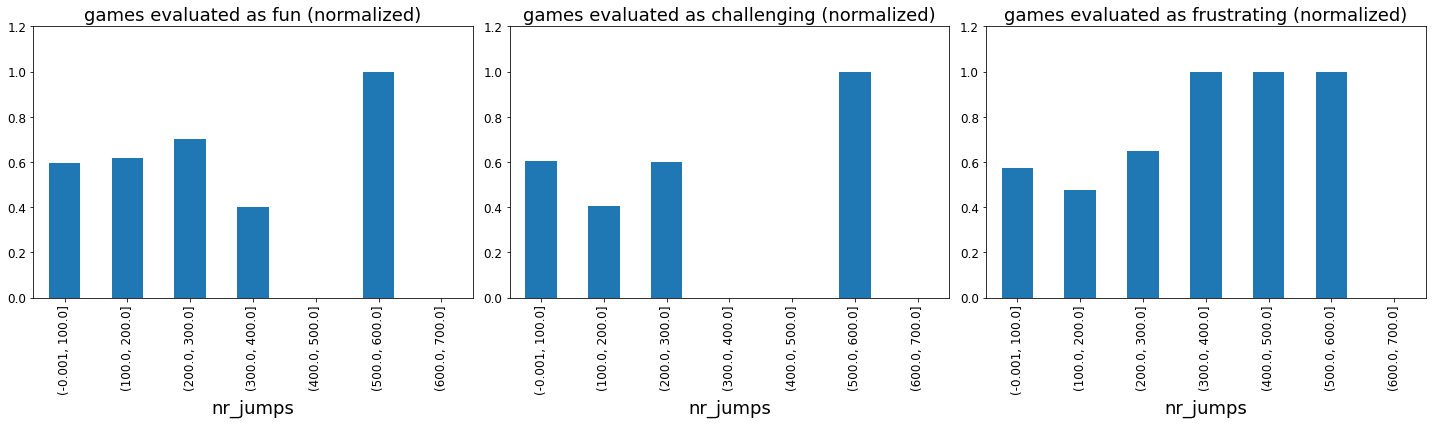

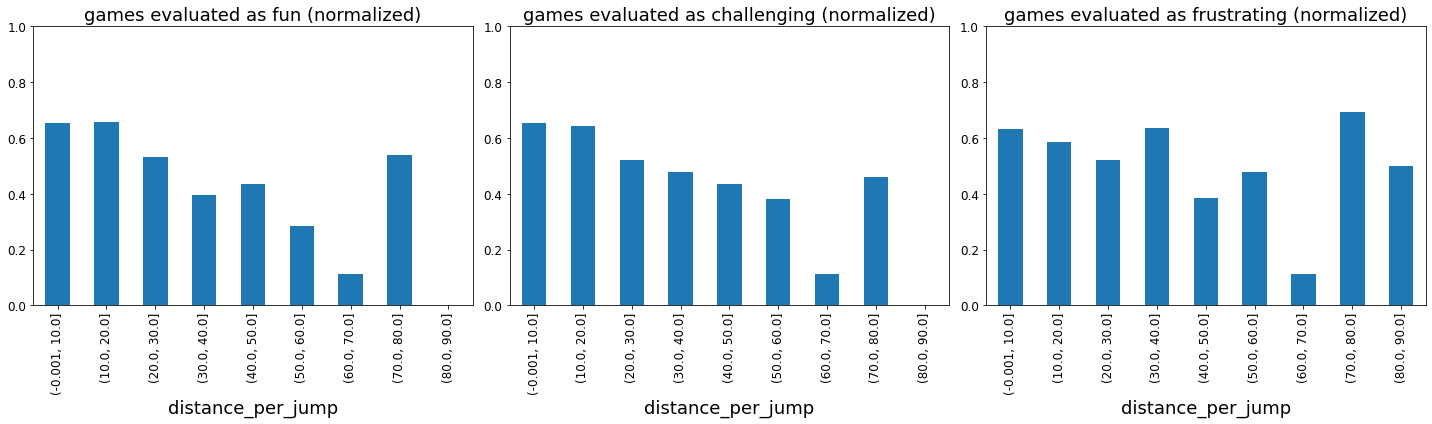

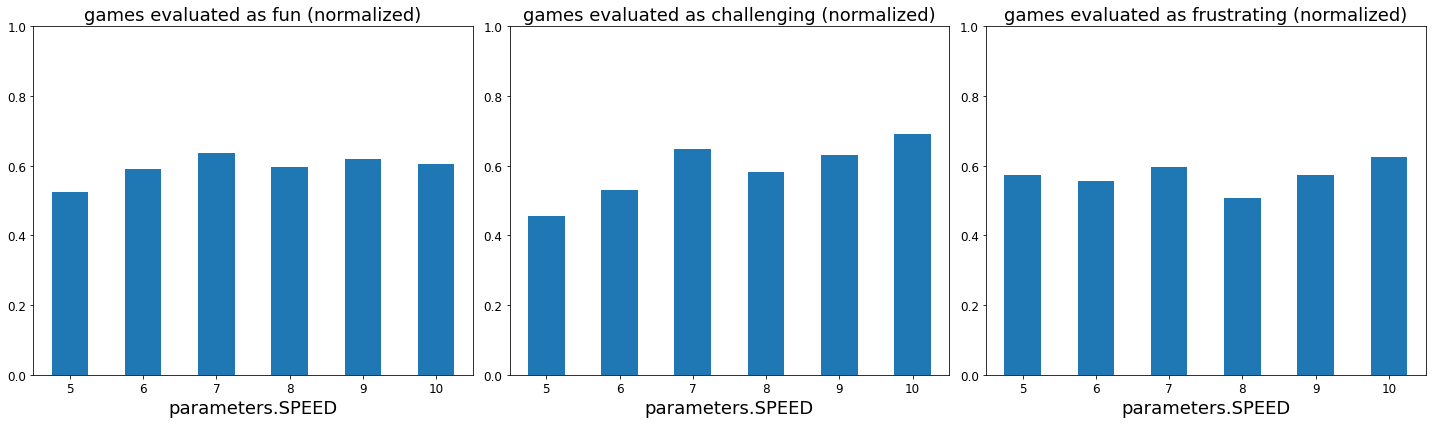

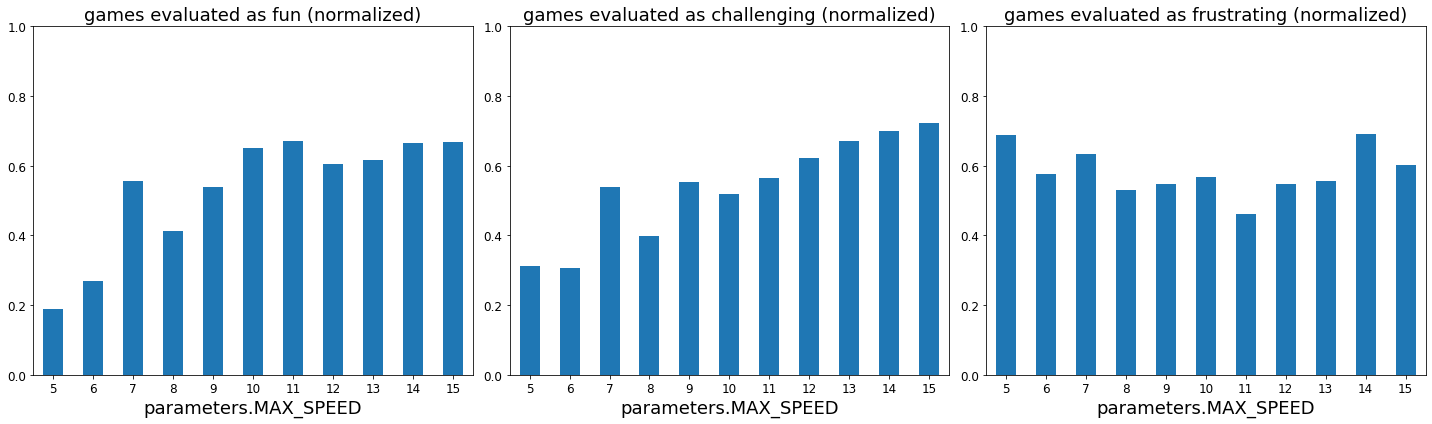

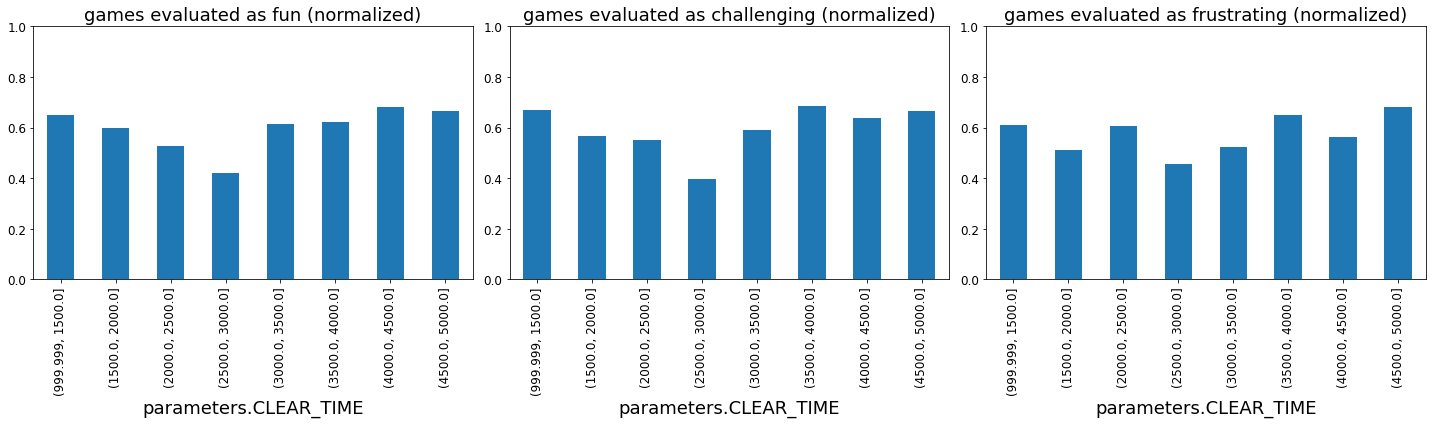

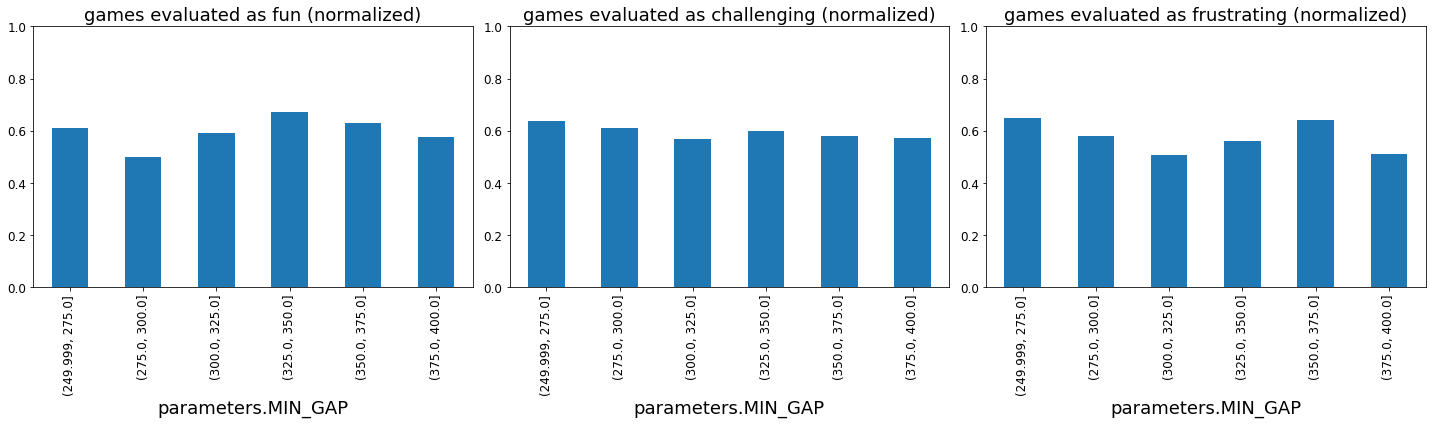

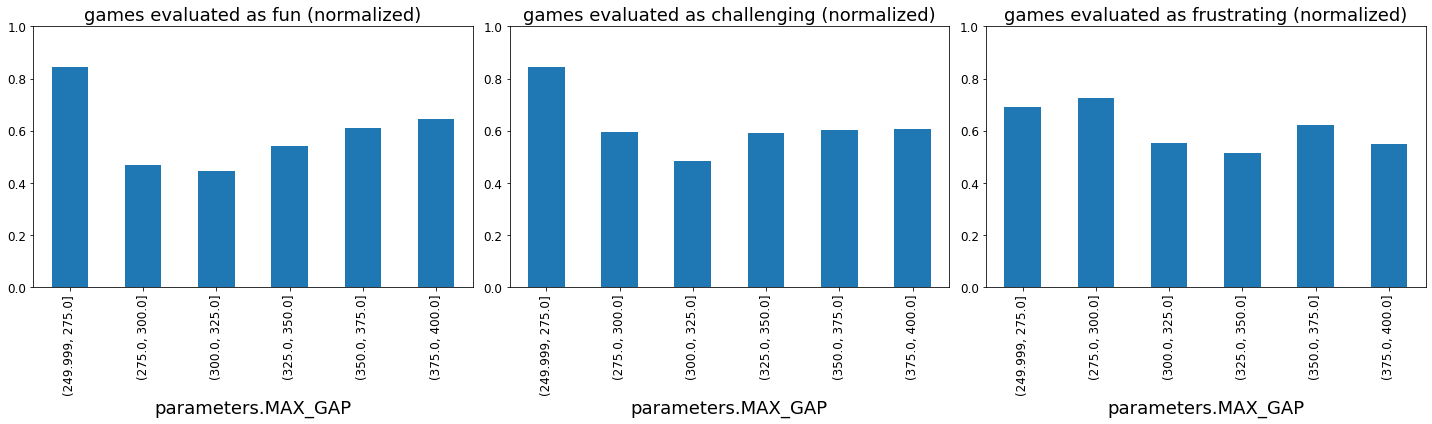

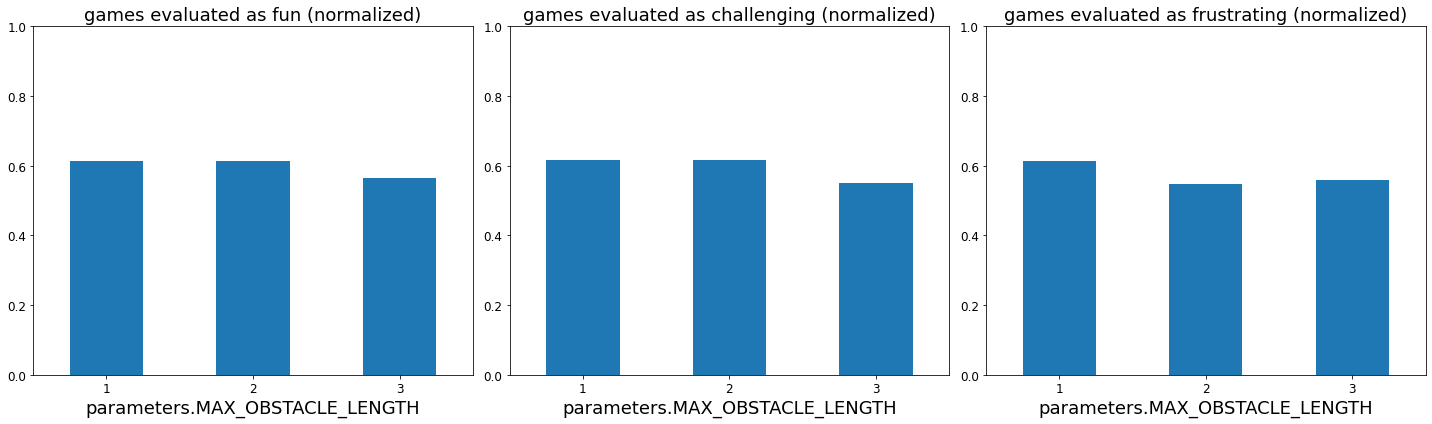

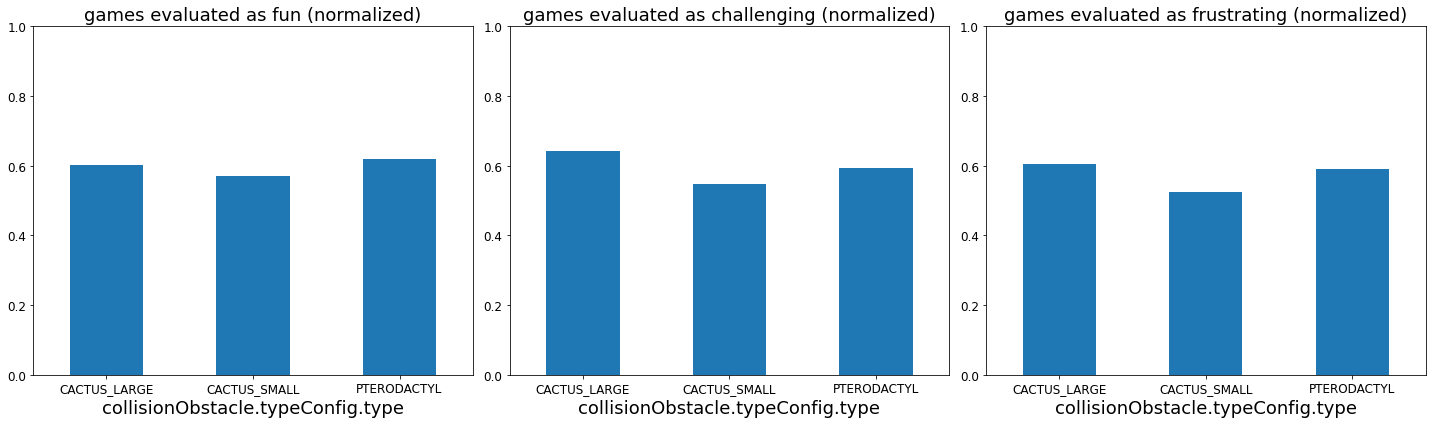

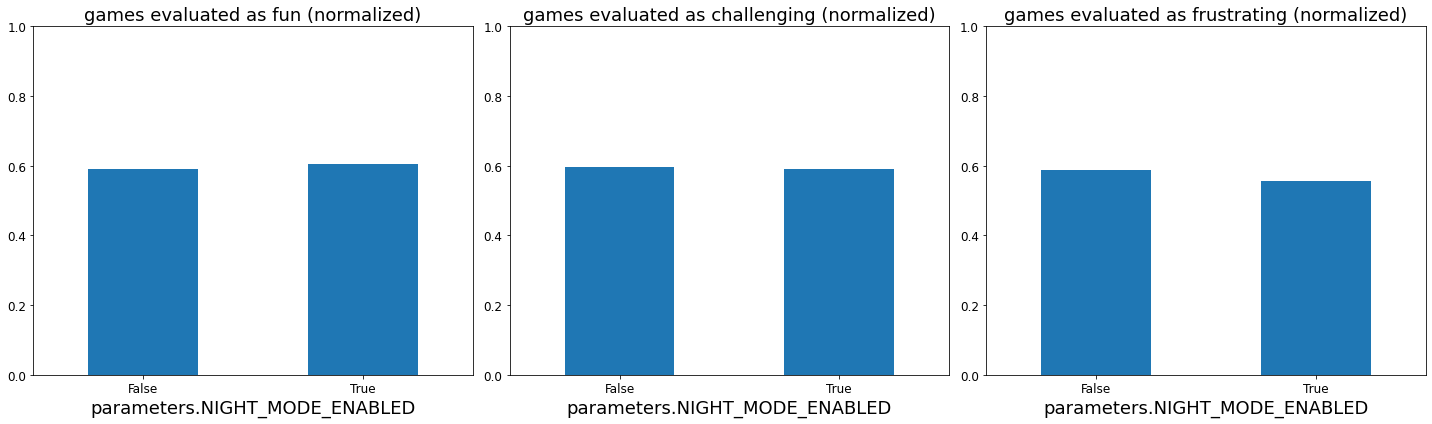

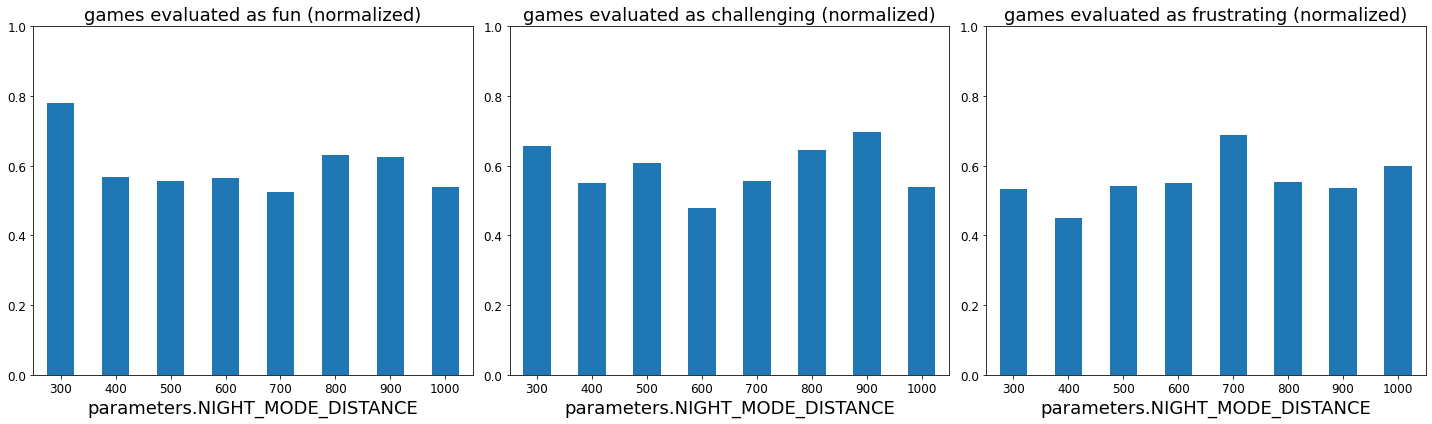

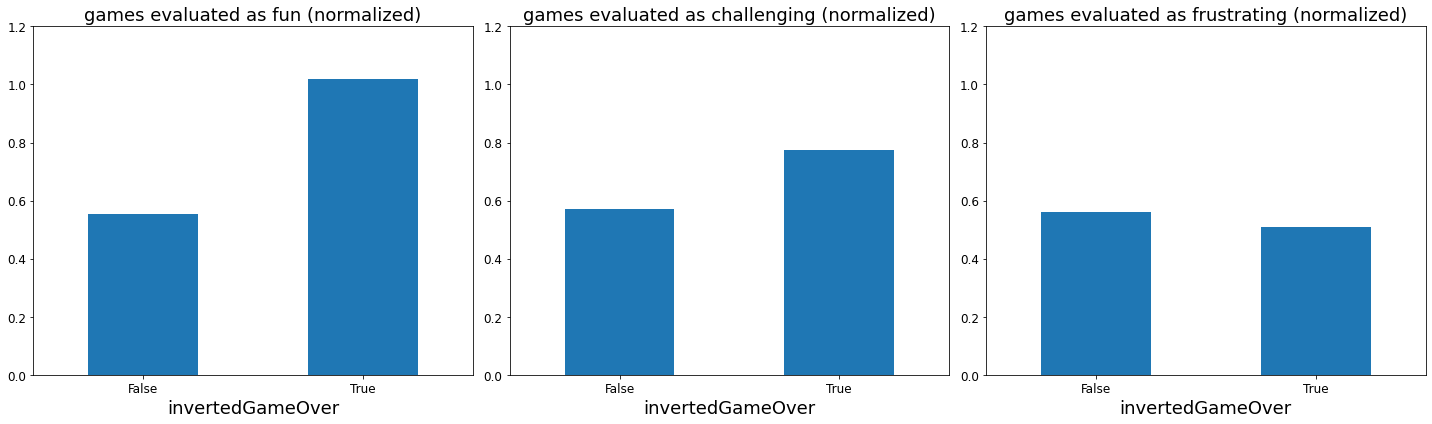

In [16]:
columns = ["fun", "challenging", "frustrating"]
def draw_positive_counts_normalized(group, y_max_range, bins = None, rotation=True):
    plt.figure(figsize=(20, 6))
    for i, column in enumerate(columns):
        plt.subplot(1, 3, i+1)
        counts = group_positive_counts(column, group, bins)
        generated = generated_group_counts(group, bins)
        #generated_max = generated.max()
        #factors = generated_max / generated
        percentages = counts / generated
        #counts_normalized = counts * factors
        ax = percentages.plot(kind="bar", xlabel=group, fontsize=12)
        ax.set_title("games evaluated as " + column + " (normalized)", fontsize=18)
        ax.set_xlabel(group, fontsize=18)
        ax.set_ylim([0,y_max_range])
        if not rotation:
            plt.xticks(rotation=0)
        plt.tight_layout()

# ! only use this for discrete values !
if(True):
    fig_name = "graphs/notebook/histograms/percentages/evaluations_percentages_"
    
    draw_positive_counts_normalized("actualDistance", 1.2, list(range(0,5000,500)))
    plt.savefig(fig_name + 'actualDistance.png')
    
    draw_positive_counts_normalized("nr_jumps", 1.2,  list(range(0,800,100)))
    plt.savefig(fig_name + 'nr_jumps.png')
    
    draw_positive_counts_normalized("distance_per_jump", 1,  list(range(0,100,10)))
    plt.savefig(fig_name + 'distance_per_jump.png')
    
    draw_positive_counts_normalized("parameters.SPEED", 1, rotation=False)
    plt.savefig(fig_name + 'speed.png')
    
    draw_positive_counts_normalized("parameters.MAX_SPEED", 1, rotation=False)
    plt.savefig(fig_name + 'max_speed.png')
    
    draw_positive_counts_normalized("parameters.CLEAR_TIME", 1, list(range(1000, 5001, 500)))
    plt.savefig(fig_name + 'clear_time.png')
    
    draw_positive_counts_normalized("parameters.MIN_GAP", 1, list(range(250,401,25)))
    plt.savefig(fig_name + 'min_gap.png')
    
    draw_positive_counts_normalized("parameters.MAX_GAP", 1, list(range(250,401,25)))
    plt.savefig(fig_name + 'max_gap.png')
    
    draw_positive_counts_normalized("parameters.MAX_OBSTACLE_LENGTH", 1, rotation=False)
    plt.savefig(fig_name + 'obstacle_length.png')
    
    draw_positive_counts_normalized("collisionObstacle.typeConfig.type", 1, rotation=False)
    plt.savefig(fig_name + 'collisionObstacle.png')
    
    draw_positive_counts_normalized("parameters.NIGHT_MODE_ENABLED", 1, rotation=False)
    plt.savefig(fig_name + 'night_mode_enabled.png')
    
    # conditional: night_mode_distance and invertedGameOver only for games where night_mode_enabled
    # ---------------------------------------------------------------------------------------------
    old_gameplays = gameplays
    sub = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
    gameplays = sub

    draw_positive_counts_normalized("parameters.NIGHT_MODE_DISTANCE", 1, rotation=False)
    plt.savefig(fig_name + 'night_mode_distance.png')    
    
    draw_positive_counts_normalized("invertedGameOver", 1.2, rotation=False)
    plt.savefig(fig_name + 'invertedGameOver.png')
    
    gameplays = old_gameplays
    # ---------------------------------------------------------------------------------------------